In [1]:
from __future__ import print_function

import subprocess
import seaborn as sns
import pandas as pd
import DyMat

from matplotlib import pyplot as plt

from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider
import ipywidgets as widgets

import numpy as np
import math
from tqdm import tqdm
import os

from scipy import fftpack

import tempfile

In [2]:
sampling_rate = 50 # Hz
simulation_time = 30

In [3]:
%cd seesaw3_build/

/home/lukas/Projects/TrussFab/src/system_simulation/seesaw3_build


In [4]:
overrides = "startTime=0,stopTime={},stepSize={},outputFormat=mat,variableFilter=revLeft.*".format(simulation_time, 1/sampling_rate)

In [5]:
time subprocess.call(["./seesaw3", "-override springDamperParallel1.c='10"])

CPU times: user 0 ns, sys: 14.8 ms, total: 14.8 ms
Wall time: 37.1 ms


0

In [6]:
subprocess.run("./seesaw3 -outputPath={} -override={} -cpu".format('.', overrides, 100), shell=True, capture_output=True)

CompletedProcess(args='./seesaw3 -outputPath=. -override=startTime=0,stopTime=30,stepSize=0.02,outputFormat=mat,variableFilter=revLeft.* -cpu', returncode=0, stdout=b'LOG_SUCCESS       | info    | The initialization finished successfully without homotopy method.\nLOG_SUCCESS       | info    | The simulation finished successfully.\n', stderr=b'')

In [7]:
subprocess.run("./seesaw3 -outputPath={} -override={} -cpu".format('.', overrides, 100), shell=True, capture_output=True)

CompletedProcess(args='./seesaw3 -outputPath=. -override=startTime=0,stopTime=30,stepSize=0.02,outputFormat=mat,variableFilter=revLeft.* -cpu', returncode=0, stdout=b'LOG_SUCCESS       | info    | The initialization finished successfully without homotopy method.\nLOG_SUCCESS       | info    | The simulation finished successfully.\n', stderr=b'')

In [8]:
def getFreq(c=100):
    with tempfile.TemporaryDirectory(dir='.') as tempdir:
        subprocess.run("./seesaw3 -outputPath={} -override {},springDamperParallel1.c='{}'".format(tempdir, overrides, c), check=True, shell=True)
        d = DyMat.DyMatFile(tempdir + '/seesaw3_res.mat')
    return d['revLeft.phi']

def getFreqPlot(c=100):
    return pd.DataFrame(getFreq(c)).plot(title="C={}".format(c))

In [9]:
def range_metric(array: np.array):
    return array.ptp()

def puke_metric(array):
    return np.absolute(np.gradient(array)).sum()

def eigenmodes_metric(x):
    return fftpack.fftfreq(len(x)) * sampling_rate

In [10]:
puke_metric([-1000,10,10,20, 100, -1000])

3175.0

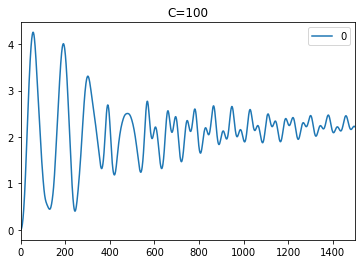

In [11]:
getFreqPlot(100)

In [12]:
def plot_eigenmodes(c=100):
    test = data[c]
    
    fig, ax = plt.subplots()
    X = fftpack.fft(test)
    
    ax.stem(eigenmodes_metric(test), np.abs(X))
    ax.set_xlabel('Frequency in Hertz [Hz]')
    ax.set_ylabel('Frequency Domain (Spectrum) Magnitude')
    ax.set_ylim(0, 300)
    ax.set_xlim(.1, 2)

In [13]:
time getFreq(10)

CPU times: user 51.7 ms, sys: 12 ms, total: 63.7 ms
Wall time: 725 ms


array([0.00000000e+00, 1.79384340e-03, 7.20830571e-03, ...,
       2.24498922e+00, 2.24790434e+00, 2.24790434e+00])

In [14]:
interact(getFreqPlot, c=(0,20000,100))

interactive(children=(IntSlider(value=100, description='c', max=20000, step=100), Output()), _dom_classes=('wi…

<function __main__.getFreqPlot(c=100)>

In [15]:
interact(plot_eigenmodes, data=(0,100,1), i=FloatSlider(min=1e5, max=1e7, step=1e5))

interactive(children=(IntSlider(value=100, description='c', max=300, min=-100), Output()), _dom_classes=('widg…

<function __main__.plot_eigenmodes(c=100)>

In [16]:
time getFreq(100)

CPU times: user 139 ms, sys: 1.01 ms, total: 140 ms
Wall time: 825 ms


array([0.00000000e+00, 1.76157706e-03, 7.07949198e-03, ...,
       2.22165703e+00, 2.21502175e+00, 2.21502175e+00])

In [17]:
# ranges = []

# for c in tqdm(range(0, 20000, 100)):
#     ranges.append(range_metric(getFreq(c)))
    
# pd.DataFrame(ranges).plot()

In [18]:
import time
import concurrent.futures

e = concurrent.futures.ThreadPoolExecutor(4)
s = range(0, 20000, 100)
# calc = lambda c: range_metric(getFreq(c))

data = [x for x in tqdm(e.map(getFreq, s))]

200it [01:04,  3.10it/s]


In [19]:
puke_index_res = [puke_metric(ts) for ts in data]

In [20]:
s[25]

2500

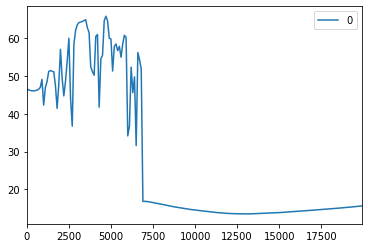

In [21]:
pd.DataFrame(puke_index_res, index=s).plot()

In [62]:
from scipy.signal import welch, find_peaks

def get_peaks(ts):
    spectrum = welch(ts, sampling_rate, nperseg=2024)
    max_freq_psd = max(spectrum[1]) 
    return [spectrum[0][i] for i, psd in enumerate(spectrum[1]) if psd == max_freq_psd][0]

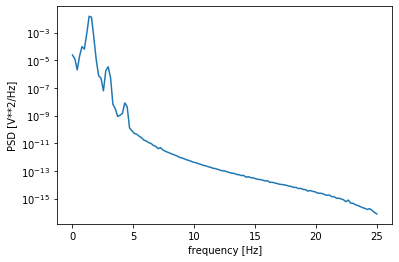

(array([  4,   7,  15,  22,  37,  72,  74,  82,  84,  94,  96, 100, 108,
        112, 116, 125]), {})

In [69]:

f, Pxx_den = welch(data[190], sampling_rate)
plt.semilogy(f, Pxx_den)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

find_peaks(Pxx_den)

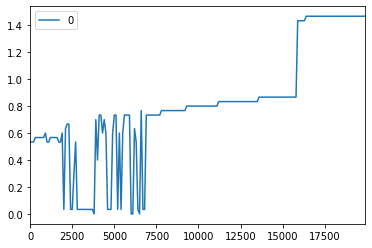

In [65]:
resonant_freq = [get_peaks(ts) for ts in data]
pd.DataFrame(resonant_freq, index=s).plot()